## ⛏️ Data Processing – Snorrebakken Wind Power (Bornholm)

The raw dataset `WPP_Snorrebakken_Bornholm.csv` contains active power measurements 
for the Snorrebakken wind power plant on Bornholm from **2020–2024**.  

### ⚠️ Challenges with the raw file
- The CSV file is **very large (~1 GB)**.  
- Timestamps are given at **second-level resolution**, with multiple or missing values per minute.  
- The assignment requires **hourly resolution**.  

### 🛠️ Processing steps
1. **Chunked reading**  
   - The file was read in chunks of 1,000,000 rows to avoid memory issues.  

2. **Cleaning**  
   - Converted the timestamp column (`ts`) into proper `datetime` objects.  
   - Renamed the long column name  
     `Snorrebakken sterled Active Power | sno_ost_effekt | 804131` → `power`.  
   - Converted power values to numeric and dropped rows with missing values.  

3. **Resampling**  
   - Instead of averaging per minute and then per hour (two-step averaging),  
     we chose **direct hourly averaging** to match the behavior in Excel:  
     - Each hourly value is the **mean of all second-level samples in that hour**.  
     - For example,  
       `2021-01-01 00:00:00` represents the mean of all samples between  
       `00:00:00` and `00:59:59` on that day.

4. **Export**  
   - The processed hourly dataset was saved as  
     `ProcessedData/WPP_Snorrebakken_Bornholm_hourly.csv`.  
   - The final file has about **43,000 rows (5 years × 8760 hours)**,  
     which is much smaller and easier to use in the ML pipeline.

5. **Sanity check**  
   - A quick time series plot confirmed the expected hourly wind power profile.  
   - Direct hourly averaging produced the same values as manual Excel calculations.

### ✅ Outcome
We now have a **clean hourly time series** of Snorrebakken’s active power, ready 
to be merged with other datasets (weather, prices, etc.) into the feature table `X`.

In [3]:
import pandas as pd

file_path = r"D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\RawData_20200101-20241231\WPP_Snorrebakken_Bornholm.csv"

# read only first 50 rows
sample = pd.read_csv(file_path, sep=",", nrows=50)
print(sample.head(20))
print(sample.columns)

                     ts  \
0   2021-01-01 00:00:00   
1   2021-01-01 00:00:04   
2   2021-01-01 00:00:05   
3   2021-01-01 00:00:15   
4   2021-01-01 00:00:24   
5   2021-01-01 00:00:25   
6   2021-01-01 00:00:32   
7   2021-01-01 00:00:35   
8   2021-01-01 00:00:40   
9   2021-01-01 00:00:41   
10  2021-01-01 00:00:44   
11  2021-01-01 00:00:45   
12  2021-01-01 00:00:54   
13  2021-01-01 00:00:55   
14  2021-01-01 00:00:58   
15  2021-01-01 00:01:00   
16  2021-01-01 00:01:02   
17  2021-01-01 00:01:05   
18  2021-01-01 00:01:15   
19  2021-01-01 00:01:25   

    Snorrebakken sterled Active Power | sno_ost_effekt | 804131  
0                                            0.115243            
1                                                 NaN            
2                                            0.115243            
3                                            0.115243            
4                                                 NaN            
5                                   

Final shape: (35064, 1)
Saved cleaned hourly data to: D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\ProcessedData\WPP_Snorrebakken_Bornholm_hourly.csv


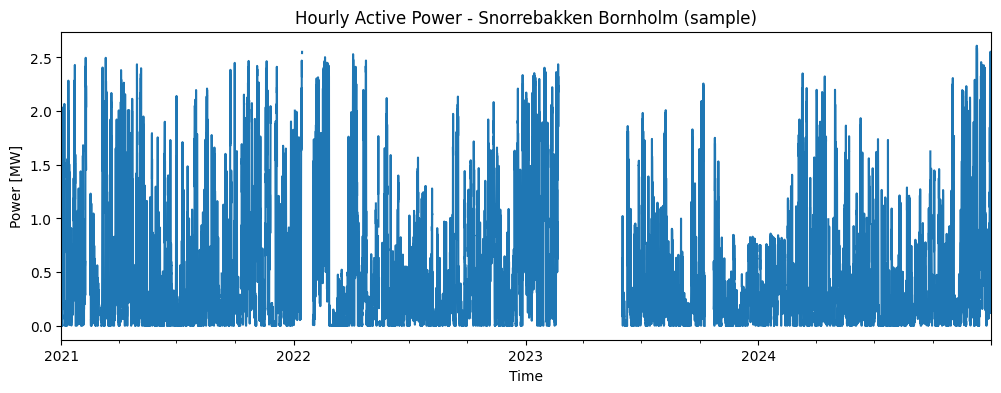

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- Paths ---
file_path = r"D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\RawData_20200101-20241231\WPP_Snorrebakken_Bornholm.csv"
out_dir = r"D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\ProcessedData"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "WPP_Snorrebakken_Bornholm_hourly.csv")

# --- Read in chunks ---
chunksize = 10**6
data_iter = pd.read_csv(file_path, sep=",", chunksize=chunksize)

cleaned_chunks = []
for chunk in data_iter:
    # rename columns consistently
    chunk = chunk.rename(columns={
        "Snorrebakken sterled Active Power | sno_ost_effekt | 804131": "power"
    })
    # parse timestamp
    chunk["ts"] = pd.to_datetime(chunk["ts"], errors="coerce")
    # convert power to numeric
    chunk["power"] = pd.to_numeric(chunk["power"], errors="coerce")
    # drop missing
    chunk = chunk.dropna(subset=["ts", "power"])
    cleaned_chunks.append(chunk[["ts", "power"]])

# Concatenate
df = pd.concat(cleaned_chunks)

# --- Resample ---
df = df.set_index("ts").sort_index()
df_min = df.resample("1min").mean()
df_hour = df_min.resample("1h").mean()

# --- Save ---
df_hour.to_csv(out_path)

print("Final shape:", df_hour.shape)
print("Saved cleaned hourly data to:", out_path)

# --- Plot ---
df_hour["power"].plot(figsize=(12, 4), title="Hourly Active Power - Snorrebakken Bornholm (sample)")
plt.ylabel("Power [MW]")
plt.xlabel("Time")
plt.show()

In [6]:
out_path = r"D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\ProcessedData\WPP_Snorrebakken_Bornholm_hourly.csv"

# Load back processed file
df_hour = pd.read_csv(out_path, parse_dates=["ts"], index_col="ts")

# Preview first and last values
print("First 10 rows:")
print(df_hour.head(10))

print("\nLast 10 rows:")
print(df_hour.tail(10))

First 10 rows:
                        power
ts                           
2021-01-01 00:00:00  0.133746
2021-01-01 01:00:00  0.221838
2021-01-01 02:00:00  0.154125
2021-01-01 03:00:00  0.127054
2021-01-01 04:00:00  0.099059
2021-01-01 05:00:00  0.005371
2021-01-01 06:00:00  0.044526
2021-01-01 07:00:00  0.016848
2021-01-01 08:00:00  0.130385
2021-01-01 09:00:00  0.074037

Last 10 rows:
                        power
ts                           
2024-12-31 14:00:00  1.864166
2024-12-31 15:00:00  1.676467
2024-12-31 16:00:00  1.923355
2024-12-31 17:00:00  1.836854
2024-12-31 18:00:00  1.679257
2024-12-31 19:00:00  1.797012
2024-12-31 20:00:00  2.071615
2024-12-31 21:00:00  2.306307
2024-12-31 22:00:00  2.175655
2024-12-31 23:00:00  2.222701


In [8]:
mask = (df.index >= "2021-01-01 00:00:00") & (df.index < "2021-01-01 01:00:00")
print("Raw average Excel-style:", df.loc[mask, "power"].mean())
print("Resample hourly:", df.resample("1h").mean().iloc[0])
print("Two-step minute->hour:", df_min.resample("1h").mean().iloc[0])

Raw average Excel-style: 0.13719387869638555
Resample hourly: power    0.137194
Name: 2021-01-01 00:00:00, dtype: float64
Two-step minute->hour: power    0.133746
Name: 2021-01-01 00:00:00, dtype: float64
